# Synthetic Data for Handle Cold Start Condition

Disclaimer: in these process below there's a bunch of assumption. Need more research.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Schema of main table training:

| task_exe_completed | task_med_completed | task_read_completed | act_exe_num | act_med_num | act_read_num | act_exe_nununique | act_med_nununique | act_read_nununique | streak_current | streak_status |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 0 | 1 | 2 | 1 | 4 | 2 | 1 | 1 | 7 | 1 |

Relations:
- `task_[category]_completed` with `streak_status`  
Assumption: more task completed = more chance `streak_status` to continue [1] (not masturbate) [vice versa]
- `act_[category]_num` with `streak_status`  
Assumption: more act num that done = more chance `streak_status` to continue [1] (not masturbate) [vice versa]
- `act_[category]_nununique` with `streak_status`  
Assumption: more act nununique that done = more chance `streak_status` to continue [1] (not masturbate) [vice versa]
- `streak_current` with `streak_status`  
Even high current_streak can be equal high chance to `streak_status` continue [1] [user still motivated to keep `streak_current` not drop] or can be high chance to `streak_status` discontinue [0] if user already addicted (high urge).

Reference: https://www.youtube.com/watch?v=PjxN1zSUnb0

User types:
- [_, _, _] => user that don't like do any task [continue:discontinue]=[10:90]
- [E, _, _] => only like exercise task [30:70]
- [M, _, _] => only like meditation task [30:70]
- [R, _, _] => only like reading task [30:70]
- [E, M, _] => only like exercise and meditation tasks [70:30]
- [E, R, _] => only like exercise and reading tasks [70:30]
- [M, R, _] => only like meditation and reading task [70:30]
- [E, M, R] => like all tasks [90:10]

Init values (assumption):
- 0 <= E (act) <= 30 (max: 3 x 10 each day)
- 0 <= M (act) <= 30
- 0 <= R (act) <= 30
- 0 <= Streak Current < 90

- Each task => 3 activities

In [3]:
def data_gen(num, config):
    data = {
        "task_exe_completed": [],
        "task_med_completed": [],
        "task_read_completed": [],
        "act_exe_num": [],
        "act_med_num": [],
        "act_read_num": [],
        "act_exe_nununique": [],
        "act_med_nununique": [],
        "act_read_nununique": [],
        "streak_current": [],
        "streak_status": [] # target feature
    }

    np.random.seed(config["seed"])
    data["task_exe_completed"] = np.ones(num, dtype=int) if config["exe"] else np.zeros(num, dtype=int)
    data["task_med_completed"] = np.ones(num, dtype=int) if config["med"] else np.zeros(num, dtype=int)
    data["task_read_completed"] = np.ones(num, dtype=int) if config["read"] else np.zeros(num, dtype=int)
    data["streak_status"] = np.random.binomial(1, config["percent_act_done"], num) # 30% [1] and 70% [0]
    data["streak_current"] = np.random.randint(config["streak_current"], size=num)
    data["act_exe_num"] = np.random.randint(30 + 1 if config["exe"] else 3, size=num) # since max 30 activities
    data["act_med_num"] = np.random.randint(30 + 1 if config["med"] else 3, size=num)
    data["act_read_num"] = np.random.randint(30 + 1 if config["read"] else 3, size=num)
    for i in range(num):
        data["act_exe_nununique"].append(np.random.randint(data["act_exe_num"][i] + 1)) # since task <= act
        data["act_med_nununique"].append(np.random.randint(data["act_med_num"][i] + 1))
        data["act_read_nununique"].append(np.random.randint(data["act_read_num"][i] + 1))
    return data

def ___(num):
    config = {
        "seed": 101,
        "exe": False,
        "med": False,
        "read": False,
        "percent_act_done": .1,
        "streak_current": 90
    }
    return data_gen(num, config)

def E__(num):
    config = {
        "seed": 202,
        "exe": True,
        "med": False,
        "read": False,
        "percent_act_done": .3,
        "streak_current": 90
    }
    return data_gen(num, config)

def M__(num):
    config = {
        "seed": 303,
        "exe": False,
        "med": True,
        "read": False,
        "percent_act_done": .3,
        "streak_current": 90
    }
    return data_gen(num, config)

def R__(num):
    config = {
        "seed": 404,
        "exe": False,
        "med": False,
        "read": True,
        "percent_act_done": .3,
        "streak_current": 90
    }
    return data_gen(num, config)

def EM_(num):
    config = {
        "seed": 505,
        "exe": True,
        "med": True,
        "read": False,
        "percent_act_done": .7,
        "streak_current": 90
    }
    return data_gen(num, config)

def ER_(num):
    config = {
        "seed": 606,
        "exe": True,
        "med": False,
        "read": True,
        "percent_act_done": .7,
        "streak_current": 90
    }
    return data_gen(num, config)

def MR_(num):
    config = {
        "seed": 707,
        "exe": False,
        "med": True,
        "read": True,
        "percent_act_done": .7,
        "streak_current": 90
    }
    return data_gen(num, config)

def EMR(num):
    config = {
        "seed": 808,
        "exe": True,
        "med": True,
        "read": True,
        "percent_act_done": .9,
        "streak_current": 90
    }
    return data_gen(num, config)

In [4]:
# In this case we will use val instead of test term
df___train, df___val = train_test_split(pd.DataFrame(___(300)), test_size=0.3)
df_e_train, df_e_val = train_test_split(pd.DataFrame(E__(300)), test_size=0.3)
df_m_train, df_m_val = train_test_split(pd.DataFrame(M__(300)), test_size=0.3)
df_r_train, df_r_val = train_test_split(pd.DataFrame(R__(300)), test_size=0.3)
df_em_train, df_em_val = train_test_split(pd.DataFrame(EM_(300)), test_size=0.3)
df_er_train, df_er_val = train_test_split(pd.DataFrame(ER_(300)), test_size=0.3)
df_mr_train, df_mr_val = train_test_split(pd.DataFrame(MR_(300)), test_size=0.3)
df_emr_train, df_emr_val = train_test_split(pd.DataFrame(EMR(300)), test_size=0.3)

In [5]:
df_train = pd.concat([df___train, df_e_train, df_m_train, df_r_train, df_em_train, df_er_train, df_mr_train, df_emr_train])
df_val = pd.concat([df___val, df_e_val, df_m_val, df_r_val, df_em_val, df_er_val, df_mr_val, df_emr_val])
df_train = shuffle(df_train)
df_val = shuffle(df_val)

In [6]:
df_train

,task_exe_completed,task_med_completed,task_read_completed,act_exe_num,act_med_num,act_read_num,act_exe_nununique,act_med_nununique,act_read_nununique,streak_current,streak_status
29,1,0,1,27,2,30,21,2,29,22,1
98,0,1,1,1,29,16,0,17,10,36,1
210,1,0,1,13,1,18,13,0,12,10,0
120,0,0,1,2,1,4,1,1,2,23,0
281,1,1,1,18,11,12,5,3,12,51,1
...,...,...,...,...,...,...,...,...,...,...,...
165,0,1,0,2,8,0,2,4,0,39,0
191,1,0,0,20,2,1,11,1,1,51,0
152,1,1,1,19,3,19,8,3,0,47,1
83,1,0,0,18,1,1,0,1,0,40,0


In [7]:
df_val

,task_exe_completed,task_med_completed,task_read_completed,act_exe_num,act_med_num,act_read_num,act_exe_nununique,act_med_nununique,act_read_nununique,streak_current,streak_status
140,0,1,1,2,18,4,2,7,3,27,1
63,0,0,1,2,0,4,0,0,4,57,0
197,0,0,0,2,1,1,2,0,1,60,0
72,0,0,0,0,2,0,0,0,0,57,0
33,1,0,1,7,1,15,3,0,3,69,1
...,...,...,...,...,...,...,...,...,...,...,...
228,0,1,0,2,11,0,1,5,0,5,0
84,0,1,1,1,1,13,1,1,9,33,1
177,1,1,0,7,9,2,0,8,2,22,1
36,0,1,0,0,10,2,0,2,2,79,0


## Check Distributions

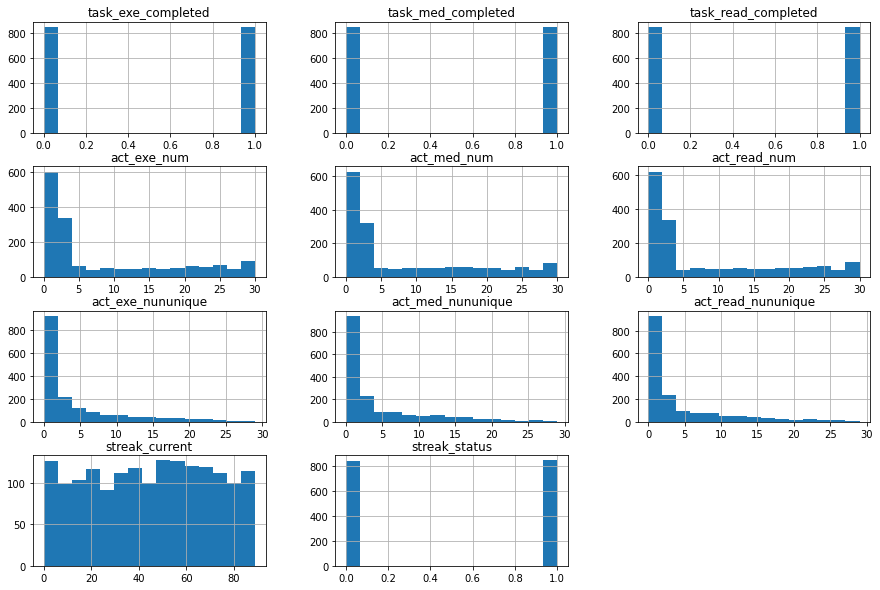

In [8]:
hist_train = df_train.hist(figsize=(15, 10), bins=15)

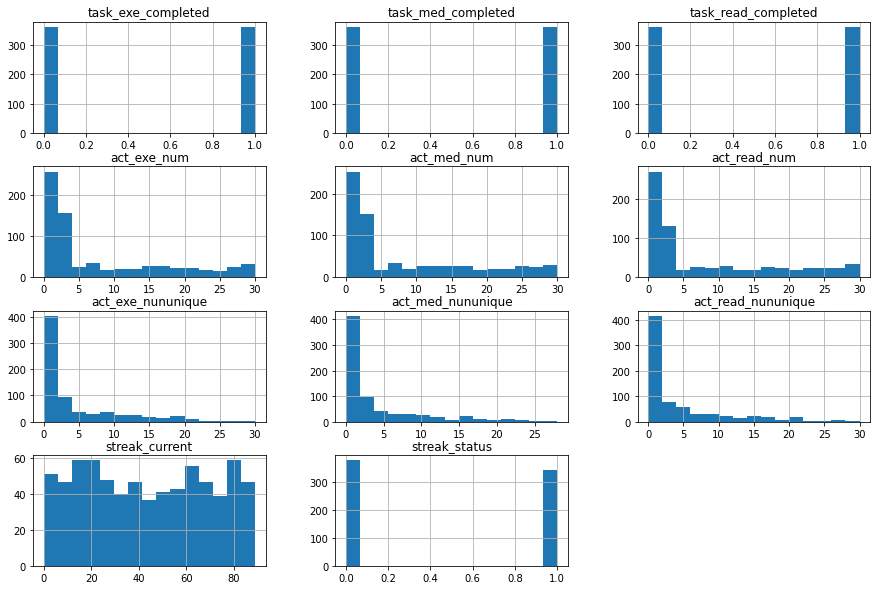

In [9]:
hist_val = df_val.hist(figsize=(15, 10), bins=15)

## Check Correlations

In [10]:
def plot_correlation_heatmap(df, title_name):
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(15, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, annot=True)
    plt.title(title_name)
    plt.show()

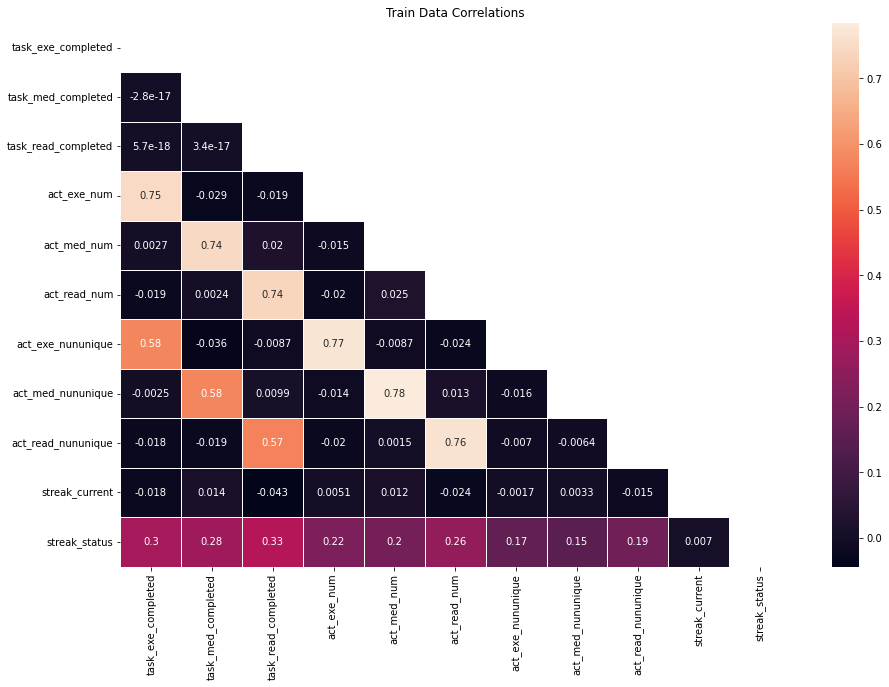

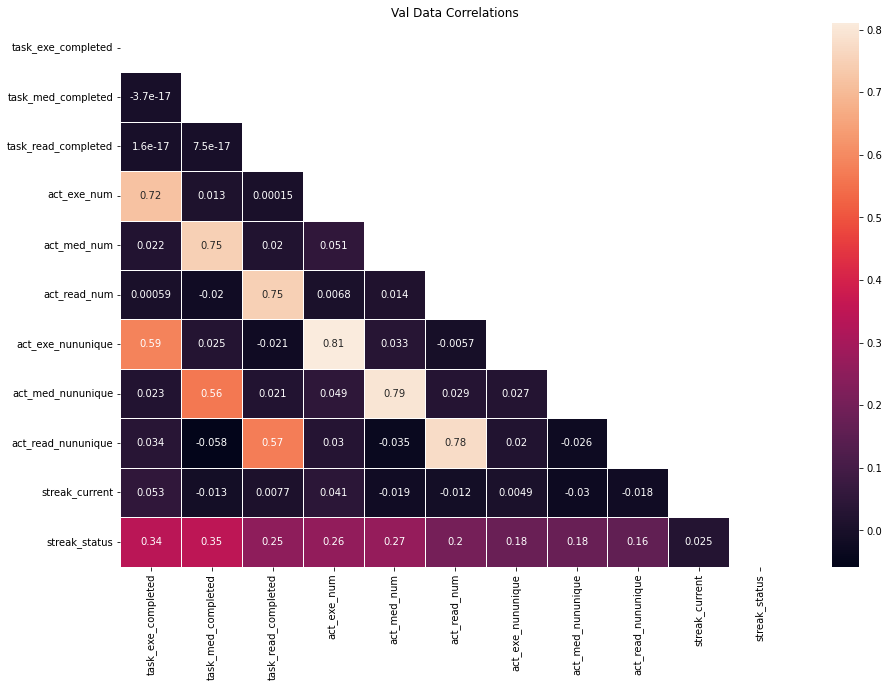

In [11]:
plot_correlation_heatmap(df_train, "Train Data Correlations")
plot_correlation_heatmap(df_val, "Val Data Correlations")

## Save Data

In [12]:
df_train.to_csv("synthetic/synth_train.csv", index=False)
df_val.to_csv("synthetic/synth_val.csv", index=False)